# Exercise Synopsys

Before opening their APIs to the public, CitiBank's Chief Digital Officer is keen in exploring new revenue streams to monetize the larges amount of data they've been historically collecting. He knows other financial institutions are doing business with their data, but he still needs to define specific use cases in which his credit card transaction data can add real value. As Senior Data Scientists, the CDO assigns you with the key task of exploring in depth the data stored in your data centers and make a solid assessment of the real value provided by it. You will present this business case in Citibank's annual convention. 

# Pip Installs

In [1]:
!pip install plotly
!pip install squarify
!pip install geopandas
!pip install dash
!pip install plotly
!pip install adjustText
!pip install joypy
!pip install to install dash_bootstrap_components
!pip install networkx

  Using cached dash_core_components-2.0.0-py3-none-any.whl (3.8 kB)
  Using cached dash_html_components-2.0.0-py3-none-any.whl (4.1 kB)
  Using cached dash_table-5.0.0-py3-none-any.whl (3.9 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dash-extensions 0.1.6 requires Flask-Caching==2.0.0, but you have flask-caching 2.0.1 which is incompatible.
dash-extensions 0.1.6 requires jsbeautifier<2.0.0,>=1.14.3, but you have jsbeautifier 1.14.0 which is incompatible.
dash-extensions 0.1.6 requires more-itertools<9.0.0,>=8.12.0, but you have more-itertools 9.0.0 which is incompatible.
  Using cached adjustText-0.7.3.tar.gz (7.5 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7074 sha256=88e8ea6c88f8b8de1cbe4ff262d7c0d9d24afcc9e0e2a992ad1216873236b4c3
  Stored in directory: /Users/karanmittal

# Imports

In [ ]:
from plotnine import *
from plotnine import ggplot, geom_map, aes, scale_fill_cmap, theme, labs
from plotnine.data import mpg
import pandas as pd
import numpy as np
import plotnine as p9
import squarify
# %matplotlib inline
# from pandas_profiling import ProfileReport
import plotly.express as px
import plotly.io as pio
import os
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.subplots import make_subplots

: 

# Importing dataframe
    

In [5]:
df = pd.read_csv ("madrid_transactions.csv", index_col=0)
countries = pd.read_csv ("country-and-continent-codes-list.csv")
df = df.merge(countries, left_on="customer_country", right_on="Two_Letter_Country_Code")

df.tx_date_proc = df.tx_date_proc.apply(pd.to_datetime)
df['Day'] = [d.date() for d in df['tx_date_proc']]
df['Time'] = [d.time() for d in df['tx_date_proc']]

country_code = pd.read_csv ("all.csv")

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

The dataset provided contains more than 10,000 credit card transactions performed by tourists in the city of Madrid during a month. CitiBank's DBA has already cleaned the file and uploaded it to the Campus Online, so you can solely focus on analyzing the different consumption patterns from tourists. The goal is to discover different insights from the data through data visualization (with GGPlot2) and then transform them into potential business outcomes. 

# Examples of Business Cases

- Is there a particular time in which tourists are buying?
- Which nationality has the highest average ticket and why?
- Is there any relationship between day of the week and consumption?
- Do high end fashion retailers need to focus more on attracting Australian visitors than on Chinese? Why? 

# Data Cleanining

In [6]:
# Reducing Country name to only first word
df['Country_Name'] = df['Country_Name'].apply(lambda x: str(x).split(',')[0])
# Reducing United Kingdom of Great Britain & Northern Ireland to United Kingdom
df['Country_Name'] = df['Country_Name'].apply(lambda x: 'United Kingdom' if x == 'United Kingdom of Great Britain & Northern Ireland' else x)

In [7]:
# Traslating to English all purchase categories
df['category'] = df['category'].apply(lambda x: 'Travel Agency' if x == 'Agencias de viajes' else x)
df['category'] = df['category'].apply(lambda x: 'Home and reforms' if x == 'Hogar y reformas' else x)
df['category'] = df['category'].apply(lambda x: 'Automotive' if x == 'Automoción' else x)

# Generating Aggregated Measures

In [8]:
df3 = df.merge(country_code, left_on="customer_country", right_on="alpha-2").groupby(['customer_country',"alpha-3", "Country_Name"])['amount'].sum().reset_index(name ='Total_Expenditure')
df4 = df.merge(country_code, left_on="customer_country", right_on="alpha-2").groupby(['customer_country',"alpha-3", "Country_Name"])['amount'].count().reset_index(name ='Total_Transactions')
df5 = df.merge(country_code, left_on="customer_country", right_on="alpha-2").groupby(['customer_country',"alpha-3", "Country_Name"])['amount'].mean().reset_index(name ='Avg_Ticket')
df_merged = df3.merge(df4, on=['customer_country', "alpha-3", "Country_Name"]).merge(df5, on=['customer_country', "alpha-3", "Country_Name"])
df_merged.sort_values(by="Total_Expenditure", ascending=False, inplace=True)

# Who are our customers and what is their expending behaviour?

## Total Expenditure

### Pareto Analysis

In [9]:
#Preparing df for pareto chart
df_merged['cumulative_sum'] = df_merged.Total_Expenditure.cumsum()
df_merged['cumulative_perc'] = 100*df_merged.cumulative_sum/df_merged.Total_Expenditure.sum()
df_merged.sort_values(by="Total_Expenditure", ascending=False, inplace=True)

In [10]:
# Pareto Chart Total Expenditure
trace_0 = go.Bar(
    x=df_merged["Country_Name"],
    y=df_merged["Total_Expenditure"],
    marker=dict(color=df_merged["Total_Expenditure"], coloraxis="coloraxis"),
    text=df_merged["Total_Expenditure"],
    textposition="outside",
    textfont=dict(color="black"),
    texttemplate='%{text:.3s}'
)

trace_1 = go.Scatter(
    x=df_merged["Country_Name"],
    y=df_merged["cumulative_perc"],
    mode="markers+lines"
)

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(trace_0)

fig.add_trace(trace_1,secondary_y=True)

fig.update_layout(
    title="Pareto Analysis: Total Expenditure by Country of Origin",
    showlegend=False,
    coloraxis_showscale=False
)

# Set y-axes titles
fig.update_yaxes(title_text="Total Expenditure", secondary_y=False),
fig.update_yaxes(title_text="Cummulativee % Total Expenditure", secondary_y=True)

fig.show()

### Geographical plot

In [11]:
df6=df_merged.merge(world, left_on="alpha-3", right_on="iso_a3")

/opt/homebrew/Caskroom/miniforge/base/envs/dashapp/lib/python3.10/site-packages/plotnine/guides/guides.py:187: PlotnineWarning:

Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it



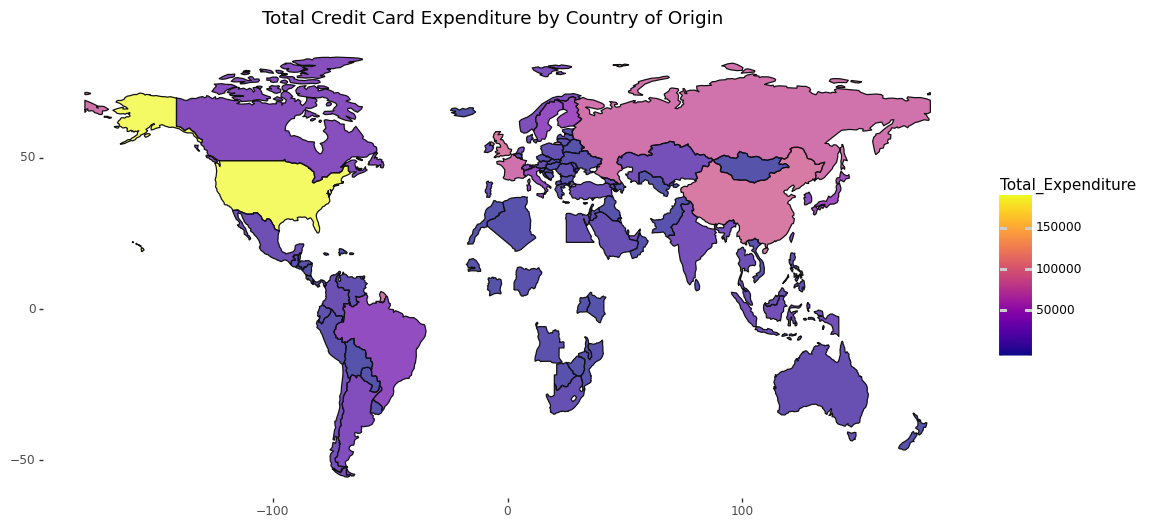

<ggplot: (402261803)>

In [12]:
chart = ggplot(df6, mapping=aes(fill="Total_Expenditure"))
map_proj = geom_map(alpha = 0.7)
labels = labs(title="Total Credit Card Expenditure by Country of Origin")
theme_details = theme(figure_size=(12,6))
fill_colormap = scale_fill_cmap(cmap_name="plasma")
color_colormap = scale_color_cmap(cmap_name="plasma")
world_map_card = chart + map_proj + labels + theme_details + fill_colormap + color_colormap + theme(panel_background = element_blank())
world_map_card

In [14]:
#Selecting Top XX nationalities
# number of top-n you want
n = 25

# group by & sort descending
df_sorted = (df6
                .groupby('Country_Name').sum()
                .sort_values('Total_Expenditure', ascending=False)
                .reset_index()
            )
# rename rows other than top-n to 'Others'
df_sorted.loc[df_sorted.index >= n, 'Country_Name'] = 'Others'

df_sorted = df_sorted.loc[df_sorted['Country_Name'] != 'Others']
# re-group by again
#df_sorted.groupby('customer_country').mean()

/var/folders/fn/7sd47lz12sz1wvc2083443v00000gn/T/ipykernel_12399/307745179.py:7: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



### Bar chart for Top 25 Countries Based on Total Expenses

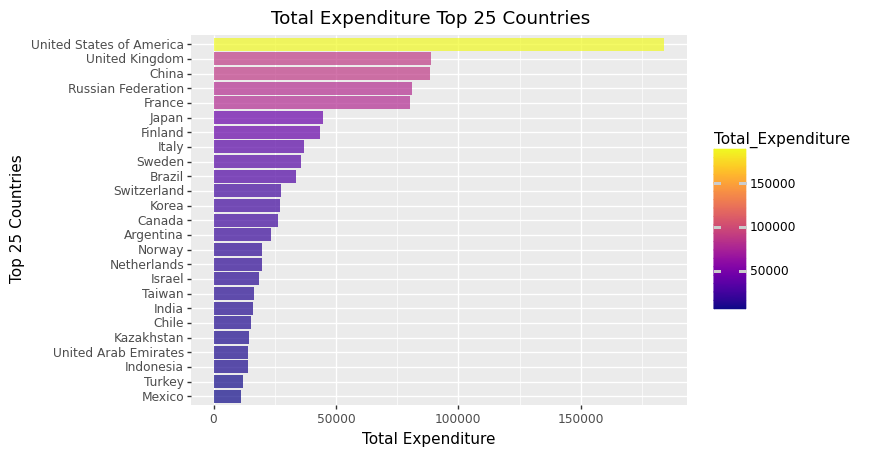

<ggplot: (402410364)>

In [15]:
#Bar Chart for top 25 countries ordered by total expenses
ggplot(df_sorted, aes(x = 'reorder(Country_Name, Total_Expenditure, fun=sum)', y = 'Total_Expenditure', fill='Total_Expenditure'))\
    + geom_bar(stat="identity",alpha = 0.7)\
        + scale_x_discrete()\
            + coord_flip()\
                +scale_fill_cmap(cmap_name="plasma")\
                    + ggtitle("Total Expenditure Top 25 Countries")\
                        +labs(y= "Total Expenditure ", x = "Top 25 Countries")                            

### Top 25 Countries Based on Total Expenses v.s Product Category

In [16]:
df7 = pd.merge(left=df, right=df_sorted[['Country_Name','Total_Expenditure']], on ='Country_Name', how ='left')
df7['Total_Expenditure'].fillna('Other', inplace=True)
df7['Total_Expenditure'] = np.where(df7['Total_Expenditure'] != 'Other', df7['Country_Name'], 'Other')
df7.rename(columns = {'Total_Expenditure':'Top_Expenditure'}, inplace = True)
df7 = df7.loc[df7['Top_Expenditure'] != 'Other']

In [17]:
df7_pivot = pd.pivot_table(df7, index=['customer_country', 'category'], values='amount', aggfunc=['sum']).reset_index()
df7_pivot1 = df7_pivot.reset_index()
df7_pivot1.columns = ['id','customer_country', 'category', 'amount']

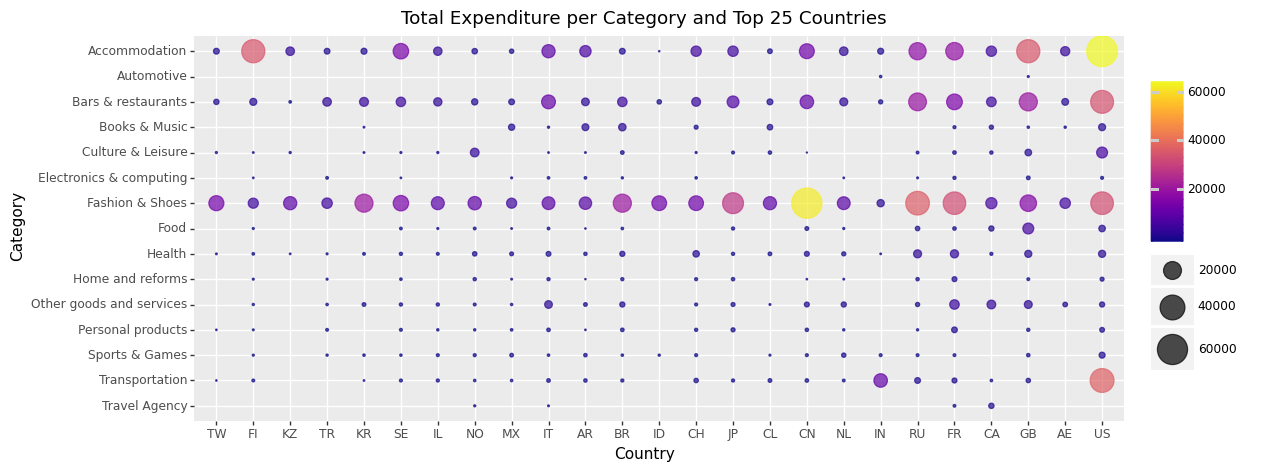

<ggplot: (398124534)>

In [18]:
ggplot(df7_pivot1, aes(x='reorder(customer_country, amount)', y='category')) +\
  geom_point(aes(size='amount', color = 'amount'),alpha = 0.7)+\
    theme(legend_title = element_blank())+\
      scale_color_cmap(cmap_name="plasma")+\
          scale_y_discrete(limits=reversed)+\
            scale_size(range=(0,12))+\
              ggtitle("Total Expenditure per Category and Top 25 Countries")+\
                labs(y= "Category", x = "Country")+\
                  theme(figure_size=(12, 5)) 

### Expenditure per Hour Top 25 Countries

In [19]:
df7_pivot2 = pd.pivot_table(df7, index=['customer_country', 'hour'], values='amount', aggfunc=['sum']).reset_index()
df7_pivot2 = df7_pivot2.reset_index()
df7_pivot2.columns = ['id','customer_country', 'hour', 'amount']

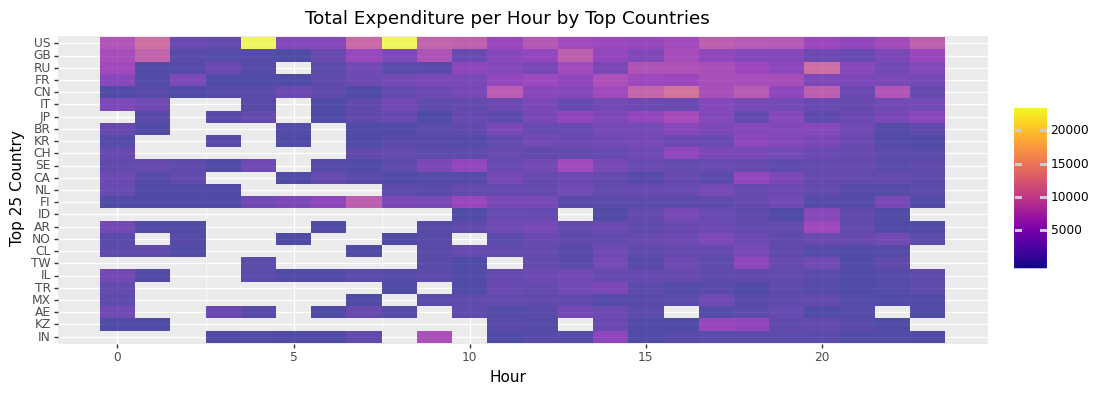

<ggplot: (676458893)>

In [20]:
ggplot(df7_pivot2)+geom_tile(aes(x='hour', y='reorder(customer_country,amount)', fill="amount"),alpha = 0.7)+\
    scale_fill_cmap(cmap_name="plasma")+\
        theme(legend_title = element_blank())+\
            ggtitle("Total Expenditure per Hour by Top Countries")+\
                labs(y= "Top 25 Country", x = "Hour")+\
                    theme(figure_size=(12, 4))

### Expenditure per Hour per Category

In [21]:
df7_pivot3 = pd.pivot_table(df7, index=['category', 'hour'], values='amount', aggfunc=['sum']).reset_index()
df7_pivot3 = df7_pivot3.reset_index()
df7_pivot3.columns = ['id','category', 'hour', 'amount']

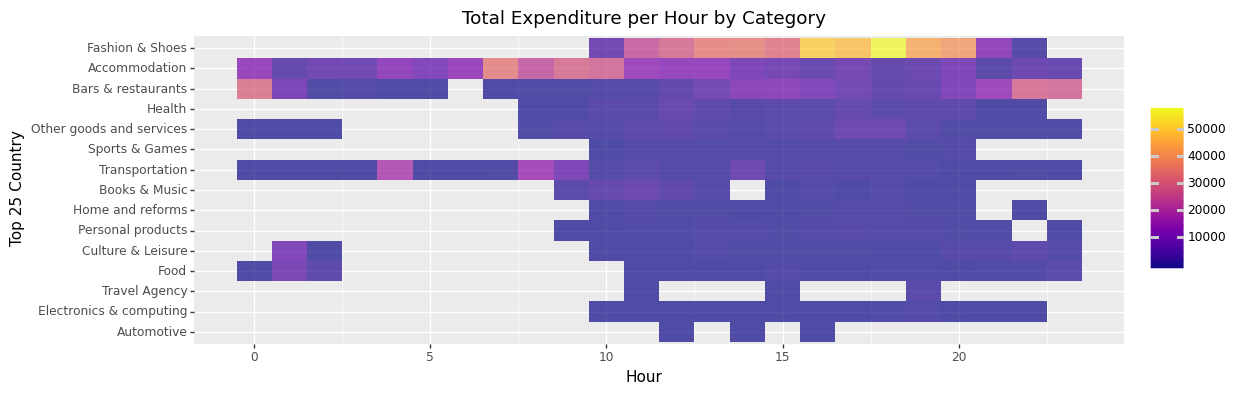

<ggplot: (402615975)>

In [22]:
ggplot(df7_pivot3)+geom_tile(aes(x='hour', y='reorder(category,amount)', fill="amount"),alpha = 0.7)+\
    scale_fill_cmap(cmap_name="plasma")+\
        theme(legend_title = element_blank())+\
            ggtitle("Total Expenditure per Hour by Category")+\
                labs(y= "Top 25 Country", x = "Hour")+\
                    theme(figure_size=(12, 4))

## Credit Card transactions volume 

### Pareto Analysis

In [23]:
#Preparing df for pareto chart
df_merged['cumulative_sum_tran'] = df_merged.Total_Transactions.cumsum()
df_merged['cumulative_perc_tran'] = 100*df_merged.cumulative_sum_tran/df_merged.Total_Transactions.sum()
df_merged.sort_values(by="Total_Transactions", ascending=False, inplace=True)

In [24]:
# Pareto Chart Total Expenditure
trace_2 = go.Bar(
    x=df_merged["Country_Name"],
    y=df_merged["Total_Transactions"],
    marker=dict(color=df_merged["Total_Transactions"], coloraxis="coloraxis"),
    text=df_merged["Total_Transactions"],
    textposition="outside",
    textfont=dict(color="black"),
    texttemplate='%{text:.3s}'
)

trace_3 = go.Scatter(
    x=df_merged["Country_Name"],
    y=df_merged["cumulative_perc_tran"],
    mode="markers+lines"
)

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(trace_2)

fig.add_trace(trace_3,secondary_y=True)

fig.update_layout(
    title="Pareto Analysis: Total Transactions by Country of Origin",
    showlegend=False,
    coloraxis_showscale=False
)

# Set y-axes titles
fig.update_yaxes(title_text="Total Transactions", secondary_y=False),
fig.update_yaxes(title_text="Cummulativee % Total Transactions", secondary_y=True)

fig.show()

### Geographical plot

/opt/homebrew/Caskroom/miniforge/base/envs/dashapp/lib/python3.10/site-packages/plotnine/guides/guides.py:187: PlotnineWarning:

Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it



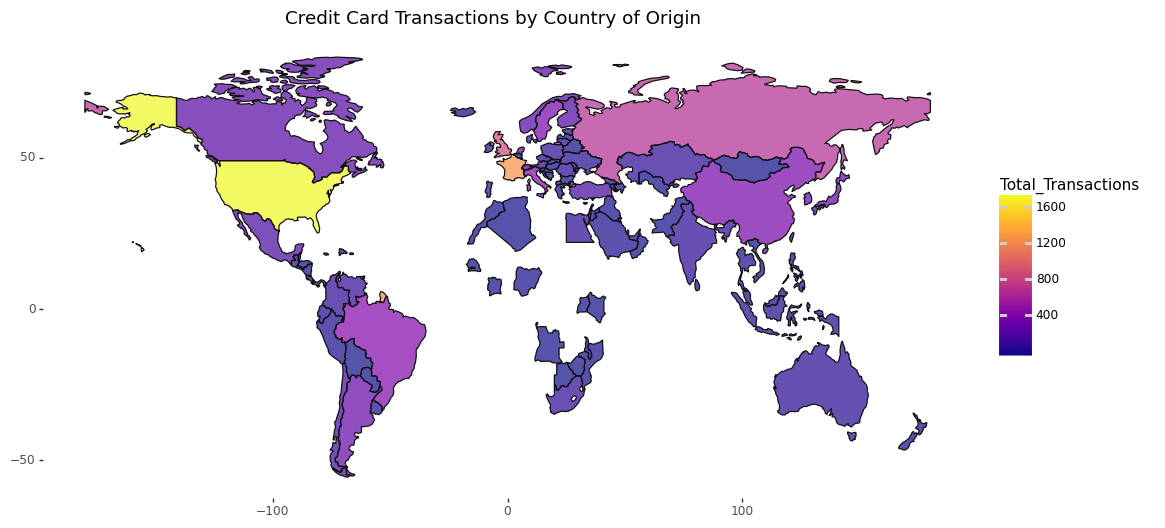

<ggplot: (402261584)>

In [25]:
chart = ggplot(df6, mapping=aes(fill="Total_Transactions"))
map_proj = geom_map(alpha = 0.7)
labels = labs(title="Credit Card Transactions by Country of Origin")
theme_details = theme(figure_size=(12,6))
fill_colormap = scale_fill_cmap(cmap_name="plasma")
color_colormap = scale_color_cmap(cmap_name="plasma")
world_map_card = chart + map_proj + labels + theme_details + fill_colormap + color_colormap + theme(panel_background = element_blank())
world_map_card

In [26]:
#Selecting Top XX nationalities
# number of top-n you want
n = 25

# group by & sort descending
df_sorted_tran = (df6
                .groupby('Country_Name').sum()
                .sort_values('Total_Transactions', ascending=False)
                .reset_index()
            )
# rename rows other than top-n to 'Others'
df_sorted_tran.loc[df_sorted_tran.index >= n, 'Country_Name'] = 'Others'

df_sorted_tran = df_sorted_tran.loc[df_sorted_tran['Country_Name'] != 'Others']
# re-group by again
#df_sorted.groupby('customer_country').mean()

/var/folders/fn/7sd47lz12sz1wvc2083443v00000gn/T/ipykernel_12399/3798371143.py:7: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



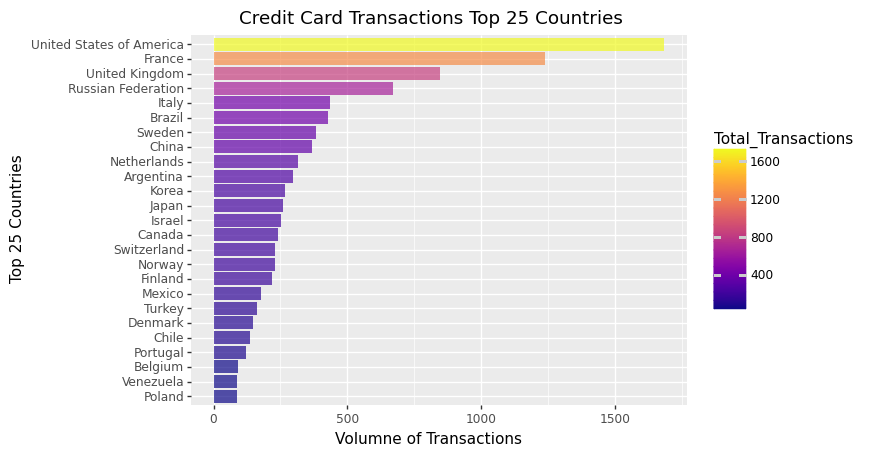

<ggplot: (395033516)>

In [27]:
#Bar Chart for top 25 countries ordered by volume of transactions
ggplot(df_sorted_tran, aes(x = 'reorder(Country_Name, Total_Transactions, fun=sum)', y = 'Total_Transactions', fill='Total_Transactions'))\
    + geom_bar(stat="identity",alpha = 0.7)\
        + scale_x_discrete()\
            + coord_flip()\
                +scale_fill_cmap(cmap_name="plasma")\
                    + ggtitle("Credit Card Transactions Top 25 Countries")\
                        +labs(y= "Volumne of Transactions ", x = "Top 25 Countries")\
                            + guides(color=guide_legend(title='Volume'))

In [28]:
df8 = pd.merge(left=df, right=df_sorted_tran[['Country_Name','Total_Transactions']], on ='Country_Name', how ='left')
df8['Total_Transactions'].fillna('Other', inplace=True)
df8['Total_Transactions'] = np.where(df8['Total_Transactions'] != 'Other', df['Country_Name'], 'Other')
df8.rename(columns = {'Total_Transactions':'Top_Transactions'}, inplace = True)
df8 = df8.loc[df8['Top_Transactions'] != 'Other']

In [29]:
df8_pivot = pd.pivot_table(df8, index=['customer_country', 'category'], values='amount', aggfunc=['count']).reset_index()
df8_pivot1 = df8_pivot.reset_index()
df8_pivot1.columns = ['id','customer_country', 'category', 'count']

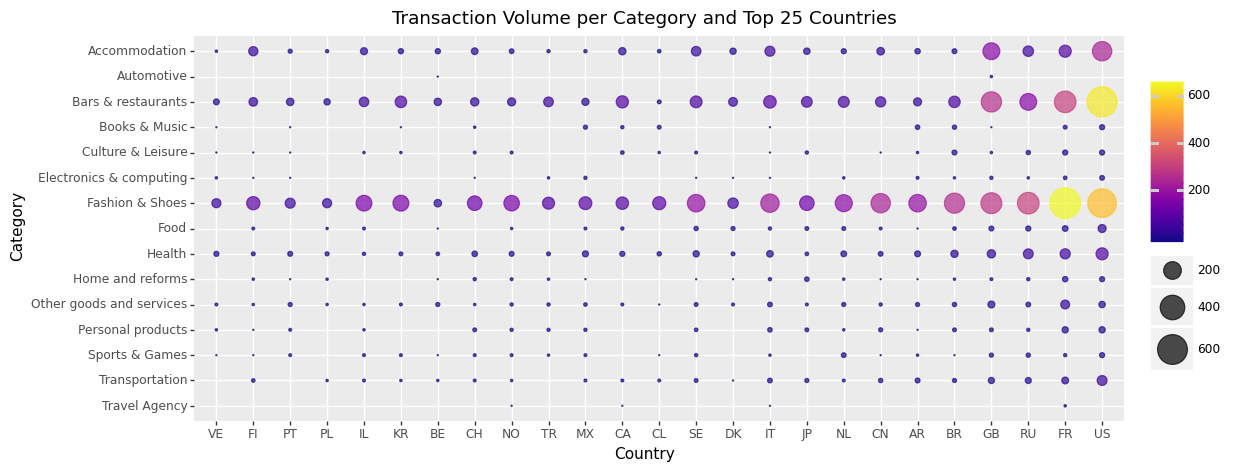

<ggplot: (676472172)>

In [30]:
ggplot(df8_pivot1, aes(x='reorder(customer_country, count)', y='category')) +\
  geom_point(aes(size='count', color = 'count'),alpha = 0.7)+\
    theme(legend_title = element_blank())+\
      scale_color_cmap(cmap_name="plasma")+\
          scale_y_discrete(limits=reversed)+\
            scale_size(range=(0,12))+\
              ggtitle("Transaction Volume per Category and Top 25 Countries")+\
                labs(y= "Category", x = "Country")+\
                  theme(figure_size=(12, 5)) 

### Transaction Volume per Hour Top 25 Countries

In [31]:
df8_pivot2 = pd.pivot_table(df8, index=['customer_country', 'hour'], values='amount', aggfunc=['count']).reset_index()
df8_pivot2 = df8_pivot2.reset_index()
df8_pivot2.columns = ['id','customer_country', 'hour', 'count']

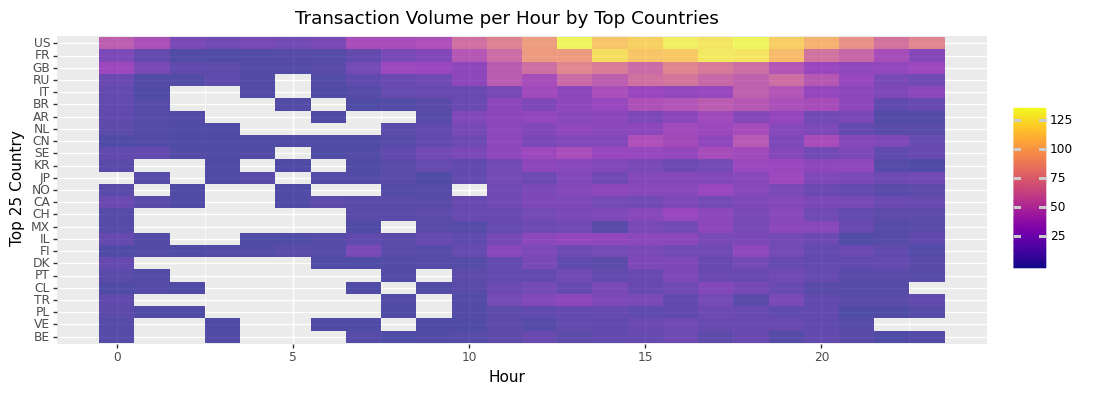

<ggplot: (676779921)>

In [32]:
ggplot(df8_pivot2)+geom_tile(aes(x='hour', y='reorder(customer_country,count)', fill="count"),alpha = 0.7)+\
    scale_fill_cmap(cmap_name="plasma")+\
        theme(legend_title = element_blank())+\
            ggtitle("Transaction Volume per Hour by Top Countries")+\
                labs(y= "Top 25 Country", x = "Hour")+\
                    theme(figure_size=(12, 4))

### Transaction Volume per Category

In [33]:
df8_pivot3 = pd.pivot_table(df8, index=['category', 'hour'], values='amount', aggfunc=['count']).reset_index()
df8_pivot3 = df8_pivot3.reset_index()
df8_pivot3.columns = ['id','category', 'hour', 'count']

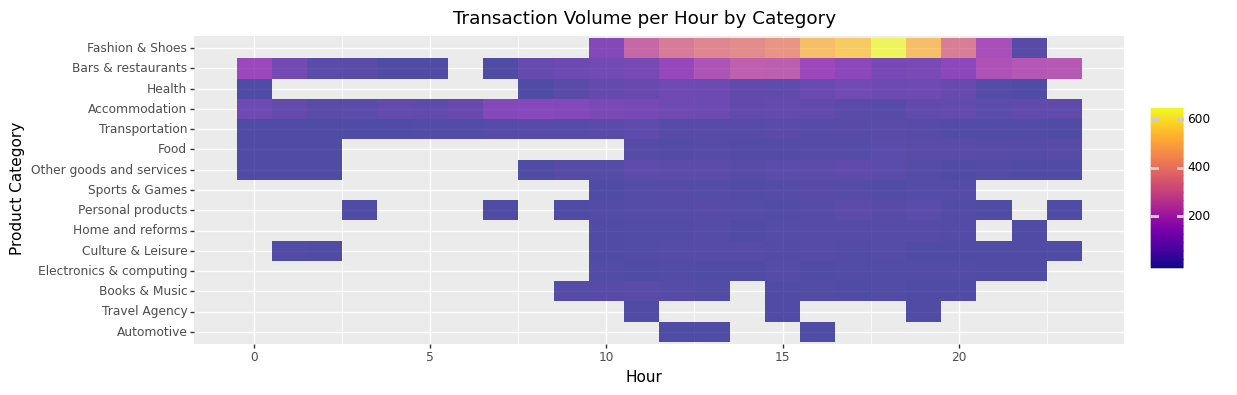

<ggplot: (676846037)>

In [34]:
ggplot(df8_pivot3)+geom_tile(aes(x='hour', y='reorder(category,count)', fill="count"),alpha = 0.7)+\
    scale_fill_cmap(cmap_name="plasma")+\
        theme(legend_title = element_blank())+\
            ggtitle("Transaction Volume per Hour by Category")+\
                labs(y= "Product Category", x = "Hour")+\
                    theme(figure_size=(12, 4))

## Average Ticket Size

### Geographical plot

/opt/homebrew/Caskroom/miniforge/base/envs/dashapp/lib/python3.10/site-packages/plotnine/guides/guides.py:187: PlotnineWarning:

Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it



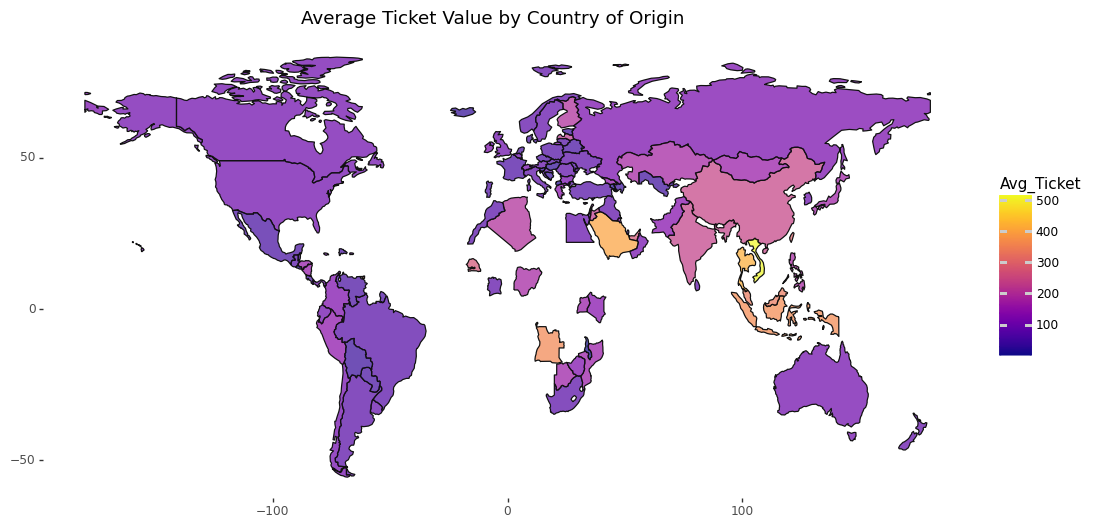

<ggplot: (676719749)>

In [35]:
chart = ggplot(data=df6, mapping=aes(fill="Avg_Ticket"))
map_proj = geom_map(alpha = 0.7)
labels = labs(title="Average Ticket Value by Country of Origin")
theme_details = theme(figure_size=(12,6))
fill_colormap = scale_fill_cmap(cmap_name="plasma")
color_colormap = scale_color_cmap(cmap_name="plasma")
world_map_card = chart + map_proj + labels + theme_details + fill_colormap + color_colormap + theme(panel_background = element_blank())
world_map_card

In [36]:
#Selecting Top XX nationalities
# number of top-n you want
n = 25

# group by & sort descending
df_sorted_avg = (df6
                .groupby('customer_country').sum()
                .sort_values('Avg_Ticket', ascending=False)
                .reset_index()
            )
# rename rows other than top-n to 'Others'
df_sorted_avg.loc[df_sorted_avg.index >= n, 'customer_country'] = 'Others'

df_sorted_avg1 = df_sorted_avg.loc[df_sorted_avg['customer_country'] != 'Others']
# re-group by again
#df_sorted.groupby('customer_country').mean()

/var/folders/fn/7sd47lz12sz1wvc2083443v00000gn/T/ipykernel_12399/1371767604.py:7: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



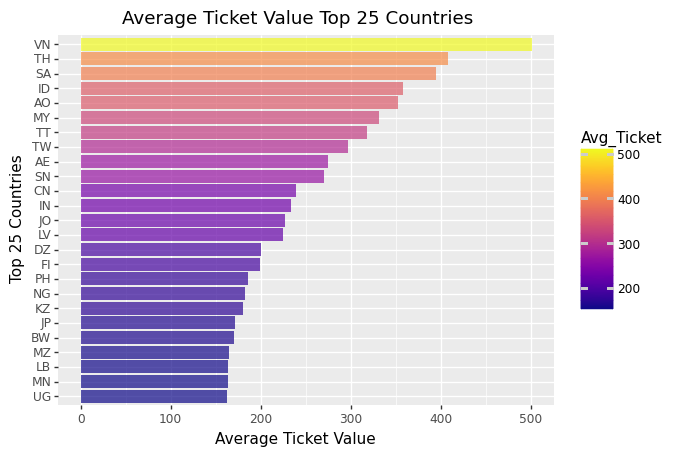

<ggplot: (677090890)>

In [37]:
#Bar Chart for top 25 countries ordered by Average Ticket Value
ggplot(df_sorted_avg1, aes(x = 'reorder(customer_country, Avg_Ticket, fun=sum)', y = 'Avg_Ticket', fill='Avg_Ticket'))\
    + geom_bar(stat="identity",alpha = 0.7)\
        + scale_x_discrete()\
            + coord_flip()\
                +scale_fill_cmap(cmap_name="plasma")\
                    + ggtitle("Average Ticket Value Top 25 Countries")\
                        +labs(y= "Average Ticket Value ", x = "Top 25 Countries")\
                            + guides(color=guide_legend(title='Avg Ticket Value'))

In [38]:
df9 = pd.merge(left=df, right=df_sorted_avg1[['customer_country','Avg_Ticket']], on ='customer_country', how ='left')
df9['Avg_Ticket'].fillna('Other', inplace=True)
df9['Avg_Ticket'] = np.where(df9['Avg_Ticket'] != 'Other', df9['customer_country'], 'Other')
df9.rename(columns = {'Avg_Ticket':'Top_Ticket'}, inplace = True)
df9 = df9.loc[df9['Top_Ticket'] != 'Other']

In [39]:
df9_pivot = pd.pivot_table(df9, index=['Top_Ticket', 'category'], values='amount', aggfunc=['mean']).reset_index()
df9_pivot1 = df9_pivot.reset_index()
df9_pivot1.columns = ['id','Top_Ticket', 'category', 'mean']

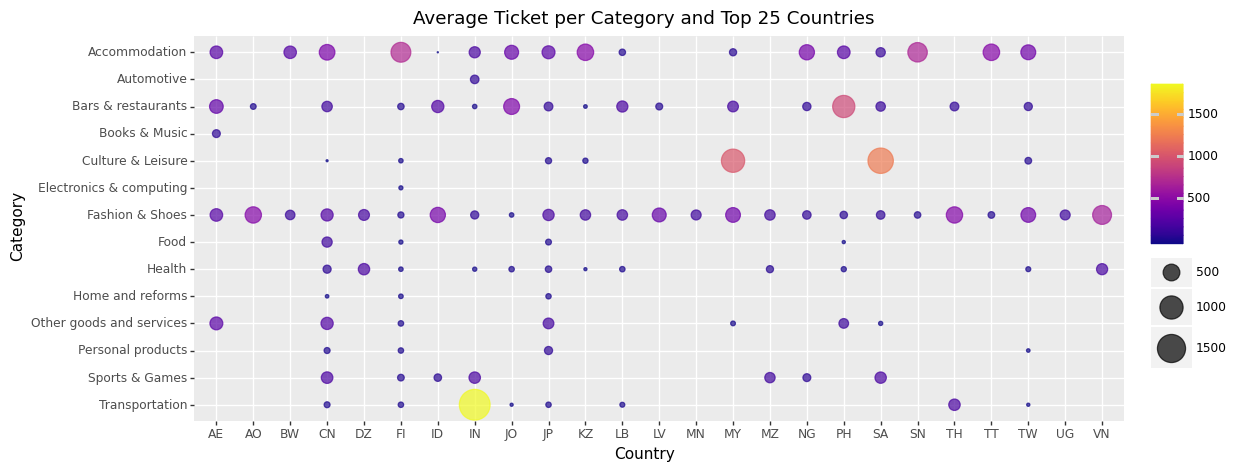

<ggplot: (402595756)>

In [40]:
ggplot(df9_pivot1, aes('Top_Ticket', 'category')) +\
  geom_point(aes(size='mean', color = 'mean'),alpha = 0.7)+\
    theme(legend_title = element_blank())+\
      scale_color_cmap(cmap_name="plasma")+\
        scale_y_discrete(limits=reversed)+\
          scale_size(range=(0,12))+\
            ggtitle("Average Ticket per Category and Top 25 Countries")+\
              labs(y= "Category", x = "Country")+\
                theme(figure_size=(12, 5)) 

### Average Ticket Size per Hour Top 25 Countries

In [41]:
df9_pivot2 = pd.pivot_table(df9, index=['customer_country', 'hour'], values='amount', aggfunc=['mean']).reset_index()
df9_pivot2 = df9_pivot2.reset_index()
df9_pivot2.columns = ['id','customer_country', 'hour', 'mean']

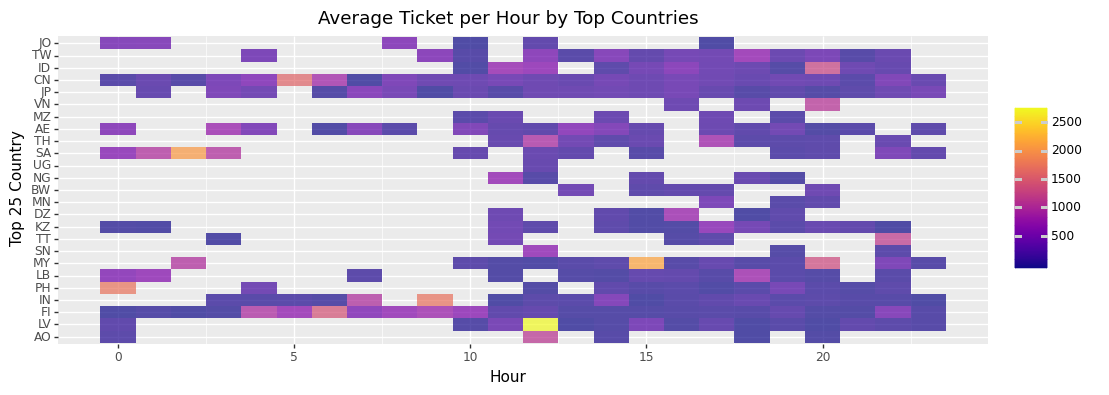

<ggplot: (679529701)>

In [42]:
ggplot(df9_pivot2)+geom_tile(aes(x='hour', y='reorder(customer_country,mean)', fill="mean"),alpha = 0.7)+\
    scale_fill_cmap(cmap_name="plasma")+\
        theme(legend_title = element_blank())+\
            ggtitle("Average Ticket per Hour by Top Countries")+\
                labs(y= "Top 25 Country", x = "Hour")+\
                    theme(figure_size=(12, 4))

### Average Ticket per Category

In [43]:
df9_pivot3 = pd.pivot_table(df9, index=['category', 'hour'], values='amount', aggfunc=['mean']).reset_index()
df9_pivot3 = df9_pivot3.reset_index()
df9_pivot3.columns = ['id','category', 'hour', 'mean']

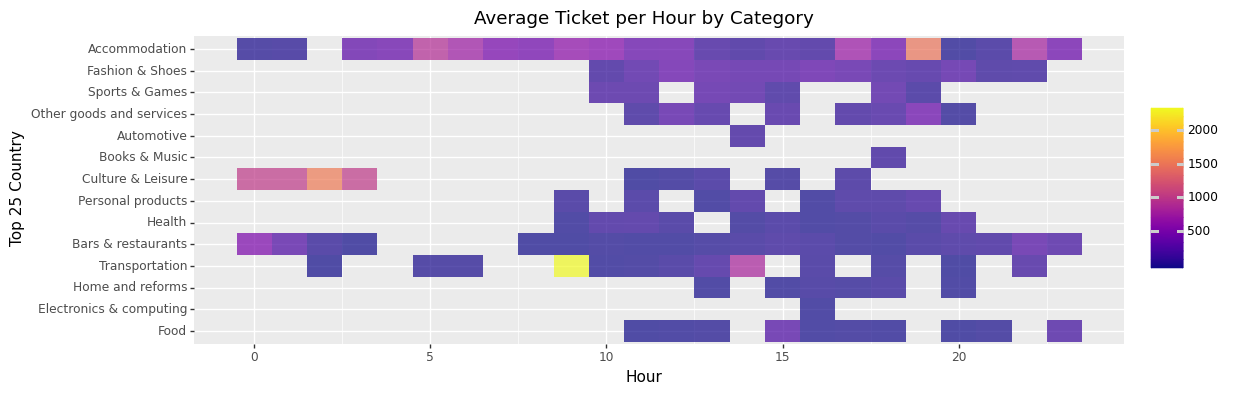

<ggplot: (402612732)>

In [44]:
ggplot(df9_pivot3)+geom_tile(aes(x='hour', y='reorder(category,mean)', fill="mean"),alpha = 0.7)+\
    scale_fill_cmap(cmap_name="plasma")+\
        theme(legend_title = element_blank())+\
            ggtitle("Average Ticket per Hour by Category")+\
                labs(y= "Top 25 Country", x = "Hour")+\
                    theme(figure_size=(12, 4))

In [45]:
df9_pivot4 = pd.pivot_table(df9, index=['category'], values='amount', aggfunc=['mean']).reset_index()
df9_pivot4 = df9_pivot4.reset_index()
df9_pivot4.columns = ['id','category', 'mean']

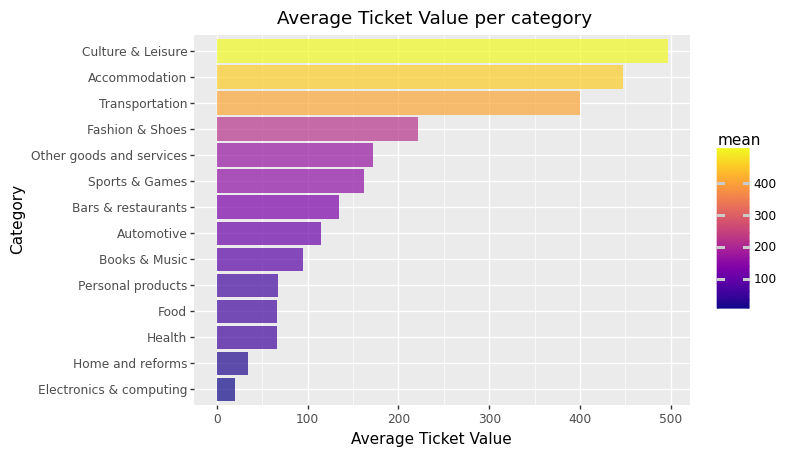

<ggplot: (676805092)>

In [46]:
ggplot(df9_pivot4, aes(x = 'reorder(category,mean)', y = 'mean', fill='mean'))\
    + geom_bar(stat="identity",alpha = 0.7)\
        + scale_x_discrete()\
            + coord_flip()\
                +scale_fill_cmap(cmap_name="plasma")\
                    + ggtitle("Average Ticket Value per category")\
                        +labs(y= "Average Ticket Value ", x = "Category")\
                            + guides(color=guide_legend(title='Avg Ticket Value'))

# Daily Purchase Habits

In [47]:
import plotly.express as px
fig = px.violin(df7_pivot3, y='category',x="hour", color = 'category', color_discrete_sequence=px.colors.sequential.Plasma_r)
fig.update_traces(orientation='h', side='positive', width=2, points=False)
fig.update_layout(title='Total Credit Card Expenditure per Purchase Category Type and Daytime',xaxis_showgrid=False, xaxis_zeroline=False, yaxis_title='Purchase Category',xaxis_range=[-5,30], xaxis_title='Hour', xaxis = dict(tickmode='linear', tick0=0, dtick=2), yaxis = dict(tickmode='linear'), showlegend=False, width=700, height=500,violinmode='group')
fig.show()

In [48]:
df_china= df.loc[df['customer_country'] == 'CN']
df_china = df_china.loc[(df_china['category'] == 'Fashion & Shoes') | (df_china['category'] == 'Accommodation') | (df_china['category'] == 'Bars & restaurants') | (df_china['category'] == 'Personal products') | (df_china['category'] == 'Other good and services') | (df_china['category'] == 'Food') | (df_china['category'] == 'Health')| (df_china['category'] == 'Transportation') ]
df_china

,amount,category,customer_country,daytime,hour,tx_date_proc,weekday,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number,Day,Time
848,49.99,Fashion & Shoes,CN,Evening,17,2012-03-02 17:34:01+00:00,friday,Asia,AS,China,CN,CHN,156.0,2012-03-02,17:34:01
849,155.62,Accommodation,CN,Afternoon,14,2012-03-02 14:11:22+00:00,friday,Asia,AS,China,CN,CHN,156.0,2012-03-02,14:11:22
850,23.98,Accommodation,CN,Mid morning,9,2012-03-02 09:32:47+00:00,friday,Asia,AS,China,CN,CHN,156.0,2012-03-02,09:32:47
851,865.90,Accommodation,CN,Mid morning,11,2012-03-02 11:07:45+00:00,friday,Asia,AS,China,CN,CHN,156.0,2012-03-02,11:07:45
852,23.90,Fashion & Shoes,CN,Mid morning,11,2012-03-01 11:08:40+00:00,thursday,Asia,AS,China,CN,CHN,156.0,2012-03-01,11:08:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,12.55,Bars & restaurants,CN,Afternoon,12,2012-03-01 12:16:57+00:00,thursday,Asia,AS,China,CN,CHN,156.0,2012-03-01,12:16:57
1213,17.42,Health,CN,Afternoon,16,2012-03-01 16:28:28+00:00,thursday,Asia,AS,China,CN,CHN,156.0,2012-03-01,16:28:28
1214,90.15,Accommodation,CN,Mid morning,9,2012-03-02 09:57:36+00:00,friday,Asia,AS,China,CN,CHN,156.0,2012-03-02,09:57:36
1215,5.60,Bars & restaurants,CN,Evening,18,2012-03-02 18:47:36+00:00,friday,Asia,AS,China,CN,CHN,156.0,2012-03-02,18:47:36


In [49]:
fig = px.violin(df_china , y='category',x="amount", color = 'category', color_discrete_sequence=px.colors.sequential.Plasma_r)
fig.update_traces(orientation='h', side='positive', width=1.5, points=False)
fig.update_layout(title='China Total Expenses Distribution',xaxis_showgrid=False, xaxis_zeroline=False, yaxis_title='Category', xaxis_title='Total Expenses', yaxis = dict(tickmode='linear'), showlegend=False, width=1000, height=400,violinmode='group')
fig.show()

In [50]:
list_Top_10_Exp =['US','GB','CN','FR','JP','FI','RU','IT','SE','BR']
df_Top_10_Exp = df7_pivot2[df7_pivot2['customer_country'].isin(list_Top_10_Exp)]

In [51]:
fig = px.violin(df_Top_10_Exp , y='customer_country',x="amount", color = 'customer_country', color_discrete_sequence=px.colors.sequential.Plasma_r)
fig.update_traces(orientation='h', side='positive', width=2, points=False)
fig.update_layout(title='Top 10 Countries based on Total Expenditure: Total Expenses Distribution',xaxis_showgrid=False, xaxis_zeroline=False, yaxis_title='Top 10 Countries based on Total Expenditure', xaxis_title='Total Expenses', yaxis = dict(tickmode='linear'), showlegend=False, width=700, height=500,violinmode='group')
fig.show()

In [52]:
df12 = pd.merge(left=df, right=df_sorted[['Country_Name','Total_Expenditure']], on ='Country_Name', how ='left')
df12['Total_Expenditure'].fillna('Other', inplace=True)
df12['Total_Expenditure'] = np.where(df12['Total_Expenditure'] != 'Other', df12['Country_Name'], 'Other')
df12.rename(columns = {'Total_Expenditure':'Top_Expenditure'}, inplace = True)

In [53]:
df12_pivot = pd.pivot_table(df12, index=['customer_country', 'hour'], values='amount', aggfunc=['sum']).reset_index()
df12_pivot1 = df12_pivot.reset_index()
df12_pivot1.columns = ['id','customer_country', 'hour', 'amount']

In [54]:
list_Top_10_Avg =['VN','TH','SA','ID','AO','MY','TT','TW','AE','SN']
df_Top_10_Avg = df12_pivot1[df12_pivot1['customer_country'].isin(list_Top_10_Avg)]

In [55]:
fig = px.violin(df_Top_10_Avg , y='customer_country',x="amount", color = 'customer_country', color_discrete_sequence=px.colors.sequential.Plasma_r)
fig.update_traces(orientation='h', side='positive', width=2, points=False)
fig.update_layout(title='Top 10 Countries based on Avg Ticket: Total Expenses Distribution',xaxis_showgrid=False, xaxis_zeroline=False, yaxis_title='Top 10 Countries based on Avg Ticket', xaxis_title='Total Expenses', yaxis = dict(tickmode='linear'), showlegend=False, width=700, height=500,violinmode='group')
fig.show()

In [56]:
df_pivot11 = pd.pivot_table(df, index=['category','daytime'], values='amount', aggfunc=['sum']).reset_index()
df11 = df_pivot11.reset_index()
df11.columns = ['id','category', 'daytime','sum_amount']

In [57]:
import plotly.express as px
fig = px.parallel_categories(df11, dimensions=['category','daytime'], color='sum_amount',color_continuous_scale= px.colors.sequential.Plasma)
fig.show()

/opt/homebrew/Caskroom/miniforge/base/envs/dashapp/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



### Sankey Diagram

In [58]:
# Helper function to transform regular data to sankey format
# Returns data and layout as dictionary
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

In [59]:
df_pivot13 = pd.pivot_table(df, index=['customer_country','category','daytime'], values='amount', aggfunc=['sum']).reset_index()
df13 = df_pivot13.reset_index()
df13.columns = ['id','customer_country','category', 'daytime','sum_amount']

In [60]:
# Generating regular sankey diagram
sank = genSankey(df13,cat_cols=['customer_country','category','daytime'],value_cols='sum_amount',title='Merchant Transactions by Day Time')
fig = go.Figure(sank)
iplot(fig)

In [61]:
# Generating DFs for different filter options
VN = genSankey(df13[df13['customer_country']=='VN'],cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
TW = genSankey(df13[df13['customer_country']=='TW'],cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
TT = genSankey(df13[df13['customer_country']=='TT'],cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
TH = genSankey(df13[df13['customer_country']=='TH'],cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
SN = genSankey(df13[df13['customer_country']=='SN'],cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
SA = genSankey(df13[df13['customer_country']=='SA'],cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
MY = genSankey(df13[df13['customer_country']=='MY'],cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
ID = genSankey(df13[df13['customer_country']=='ID'],cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
AO = genSankey(df13[df13['customer_country']=='AO'],cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
AE = genSankey(df13[df13['customer_country']=='AE'],cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
US = genSankey(df13[df13['customer_country']=='US'],cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
FR = genSankey(df13[df13['customer_country']=='FR'],cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
RU = genSankey(df13[df13['customer_country']=='RU'],cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
GB = genSankey(df13[df13['customer_country']=='GB'],cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
BR = genSankey(df13[df13['customer_country']=='BR'],cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
CN = genSankey(df13[df13['customer_country']=='CN'],cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
JP = genSankey(df13[df13['customer_country']=='JP'],cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
all = genSankey(df13,cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')


# Constructing menus
updatemenus = [{'buttons': [{'method': 'animate','label': 'All','args': [all]},
                            {'method': 'animate','label': 'Vietnam','args': [VN]},
                            {'method': 'animate','label': 'Taiwan','args': [TW]},
                            {'method': 'animate','label': 'Trinidad and Tobago','args': [TT]},
                            {'method': 'animate','label': 'Vietnam','args': [TH]},
                            {'method': 'animate','label': 'Thailand','args': [SN]},
                            {'method': 'animate','label': 'Saudi Arabia','args': [SA]},
                            {'method': 'animate','label': 'Malesya','args': [MY]},
                            {'method': 'animate','label': 'Indonesia','args': [ID]},
                            {'method': 'animate','label': 'Angola','args': [AO]},
                            {'method': 'animate','label': 'United Arab Emirates','args': [AE]},
                            {'method': 'animate','label': 'United States','args': [US]},
                            {'method': 'animate','label': 'France','args': [FR]},
                            {'method': 'animate','label': 'Russia','args': [RU]},
                            {'method': 'animate','label': 'United Kingdom','args': [GB]},
                            {'method': 'animate','label': 'Brazil','args': [BR]},
                            {'method': 'animate','label': 'China','args': [CN]},
                            {'method': 'animate','label': 'Japon','args': [JP]},
                            ] } ]

# update layout with buttons, and show the figure
sank = genSankey(df13,cat_cols=['customer_country','daytime','category'],value_cols='sum_amount',title='Merchant Transactions by Day Time')
fig = go.Figure(sank)
fig.update_layout(updatemenus=updatemenus, width=700, height=500)
fig.update_layout(
)
iplot(fig)

# Use dropdown below to interact with the plot

In [62]:
# Generating DFs for different filter options
Fashion = genSankey(df13[df13['category']=='Fashion & Shoes'],cat_cols=['category','daytime','customer_country'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
Bar = genSankey(df13[df13['category']=='Bar & restaurants'],cat_cols=['category','daytime','customer_country'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
Health = genSankey(df13[df13['category']=='Health'],cat_cols=['category','daytime','customer_country'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
Accomodation = genSankey(df13[df13['category']=='Accomodation'],cat_cols=['category','daytime','customer_country'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
Transportation = genSankey(df13[df13['category']=='Transportation'],cat_cols=['category','daytime','customer_country'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
Food = genSankey(df13[df13['category']=='Food'],cat_cols=['category','daytime','customer_country'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
Other = genSankey(df13[df13['category']=='Other goods and services'],cat_cols=['category','daytime','customer_country'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
Sport = genSankey(df13[df13['category']=='Sport & Games'],cat_cols=['category','daytime','customer_country'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
Personal = genSankey(df13[df13['category']=='Personal Products'],cat_cols=['category','daytime','customer_country'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
Home = genSankey(df13[df13['category']=='Home and reforms'],cat_cols=['category','daytime','customer_country'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
Culture = genSankey(df13[df13['category']=='Culture a& Leasure'],cat_cols=['category','daytime','customer_country'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
Electronics = genSankey(df13[df13['category']=='Electronics & Computing'],cat_cols=['category','daytime','customer_country'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
Books = genSankey(df13[df13['category']=='Books & Music'],cat_cols=['category','daytime','customer_country'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
Travel = genSankey(df13[df13['category']=='Travel Agency'],cat_cols=['category','daytime','customer_country'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
Automotive = genSankey(df13[df13['category']=='Automotive'],cat_cols=['category','daytime','customer_country'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
all = genSankey(df13,cat_cols=['category','daytime','customer_country'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')

# Constructing menus
updatemenus = [{'buttons': [{'method': 'animate','label': 'All','args': [all]},
                            {'method': 'animate','label': 'Fashion & Shoes','args': [Fashion]},
                            {'method': 'animate','label': 'Bar & restaurants','args': [Bar]},
                            {'method': 'animate','label': 'Health','args': [Health]},
                            {'method': 'animate','label': 'Accomodation','args': [Accomodation]},
                            {'method': 'animate','label': 'Transportation','args': [Transportation]},
                            {'method': 'animate','label': 'Food','args': [Food]},
                            {'method': 'animate','label': 'Other goods and services','args': [Other]},
                            {'method': 'animate','label': 'Sport & Games','args': [Sport]},
                            {'method': 'animate','label': 'Personal Products','args': [Personal]},
                            {'method': 'animate','label': 'Home and reforms','args': [Home]},
                            {'method': 'animate','label': 'Culture and Leasure','args': [Culture]},
                            {'method': 'animate','label': 'Electronics and Computing','args': [Electronics]},
                            {'method': 'animate','label': 'Books and Music','args': [Books]},
                            {'method': 'animate','label': 'Travel Agency','args': [Travel]},
                            {'method': 'animate','label': 'Automotive','args': [Automotive]},
                            ] } ]

# update layout with buttons, and show the figure
sank = genSankey(df13,cat_cols=['category','daytime','customer_country'],value_cols='sum_amount',title='Merchant Transactions by Day Time')
fig = go.Figure(sank)
fig.update_layout(updatemenus=updatemenus, width=700, height=500)
fig.update_layout(
)
iplot(fig)

# Use dropdown below to interact with the plot

In [63]:
# Generating DFs for different filter options
VN = genSankey(df13[df13['customer_country']=='VN'],cat_cols=['category','daytime'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
TW = genSankey(df13[df13['customer_country']=='TW'],cat_cols=['category','daytime'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
TT = genSankey(df13[df13['customer_country']=='TT'],cat_cols=['category','daytime'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
TH = genSankey(df13[df13['customer_country']=='TH'],cat_cols=['category','daytime'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
SN = genSankey(df13[df13['customer_country']=='SN'],cat_cols=['category','daytime'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
SA = genSankey(df13[df13['customer_country']=='SA'],cat_cols=['category','daytime'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
MY = genSankey(df13[df13['customer_country']=='MY'],cat_cols=['category','daytime'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
ID = genSankey(df13[df13['customer_country']=='ID'],cat_cols=['category','daytime'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
AO = genSankey(df13[df13['customer_country']=='AO'],cat_cols=['category','daytime'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
AE = genSankey(df13[df13['customer_country']=='AE'],cat_cols=['category','daytime'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
US = genSankey(df13[df13['customer_country']=='US'],cat_cols=['category','daytime'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
FR = genSankey(df13[df13['customer_country']=='FR'],cat_cols=['category','daytime'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
RU = genSankey(df13[df13['customer_country']=='RU'],cat_cols=['category','daytime'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
GB = genSankey(df13[df13['customer_country']=='GB'],cat_cols=['category','daytime'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
BR = genSankey(df13[df13['customer_country']=='BR'],cat_cols=['category','daytime'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
CN = genSankey(df13[df13['customer_country']=='CN'],cat_cols=['category','daytime'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
JP = genSankey(df13[df13['customer_country']=='JP'],cat_cols=['category','daytime'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')
all = genSankey(df13,cat_cols=['category','daytime'],value_cols='sum_amount',title='Country Expenditure by Merchant Transactions and Day Time')


# Constructing menus
updatemenus = [{'buttons': [{'method': 'animate','label': 'All','args': [all]},
                            {'method': 'animate','label': 'Vietnam','args': [VN]},
                            {'method': 'animate','label': 'Taiwan','args': [TW]},
                            {'method': 'animate','label': 'Trinidad and Tobago','args': [TT]},
                            {'method': 'animate','label': 'Vietnam','args': [TH]},
                            {'method': 'animate','label': 'Thailand','args': [SN]},
                            {'method': 'animate','label': 'Saudi Arabia','args': [SA]},
                            {'method': 'animate','label': 'Malesya','args': [MY]},
                            {'method': 'animate','label': 'Indonesia','args': [ID]},
                            {'method': 'animate','label': 'Angola','args': [AO]},
                            {'method': 'animate','label': 'United Arab Emirates','args': [AE]},
                            {'method': 'animate','label': 'United States','args': [US]},
                            {'method': 'animate','label': 'France','args': [FR]},
                            {'method': 'animate','label': 'Russia','args': [RU]},
                            {'method': 'animate','label': 'United Kingdom','args': [GB]},
                            {'method': 'animate','label': 'Brazil','args': [BR]},
                            {'method': 'animate','label': 'China','args': [CN]},
                            {'method': 'animate','label': 'Japon','args': [JP]},
                            ] } ]

# update layout with buttons, and show the figure
sank = genSankey(df13,cat_cols=['category','daytime'],value_cols='sum_amount',title='Merchant Transactions by Day Time')
fig = go.Figure(sank)
fig.update_layout(updatemenus=updatemenus, width=700, height=500)
fig.update_layout(
)
iplot(fig)

# Use dropdown below to interact with the plot

In [64]:
import plotly.express as px
import pandas as pd

fig= px.bar_polar(df11, r="sum_amount", theta = "category",
                 color = "daytime", template = "ggplot2",
                 color_discrete_sequence = px.colors.sequential.Plasma_r)
fig.update_layout(
    title='Total Credit Card Expenditure per Purchase Category Type and Daytime',
    font_size=12,
    legend_font_size=12,
    width=800, 
    height=500
)
fig.show()

### Targeting our Market

#### Transaction Volume v.s. Total Expenditure

In [65]:
conditions = [
    (df6['Total_Expenditure'] >= 9400) & (df6['Total_Transactions'] >= 6.5),
    (df6['Total_Expenditure'] < 9400) & (df6['Total_Transactions'] >= 6.5),
    (df6['Total_Transactions'] < 6.5)
    ]

# create a list of the values we want to assign for each condition
values = ['tier_3', 'tier_2', 'tier_1']

In [66]:
df6['Tier'] = np.select(conditions, values)

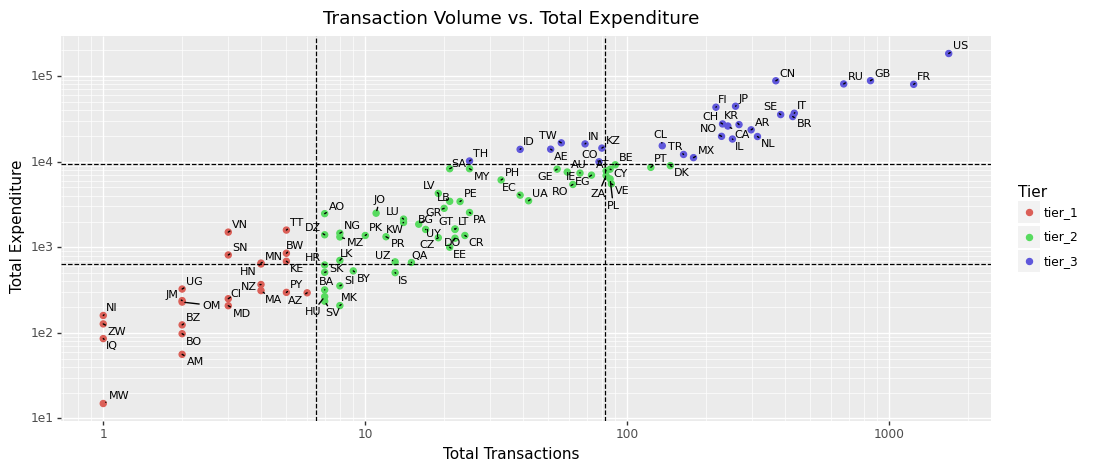

<ggplot: (683005094)>

In [67]:
from adjustText import adjust_text
ggplot(df6 , aes(x='Total_Transactions', y='Total_Expenditure'))+\
    geom_point(aes(color='Tier'), size = 2)+\
      scale_x_continuous(trans='log10')+\
        scale_y_continuous(trans='log10')+\
          ggtitle("Transaction Volume vs. Total Expenditure")+\
            geom_text(aes(label="customer_country"), colour = "black", size = 8, nudge_y=0.2, show_legend=False, adjust_text={'expand_points': (1.5, 1.5), 'arrowprops': {'arrowstyle': '-'}})+\
              geom_hline(yintercept=9400, linetype="dashed", color = "black")+\
                geom_hline(yintercept=630, linetype="dashed", color = "black")+\
                  geom_vline(xintercept=82.25, linetype="dashed", color = "black")+\
                    geom_vline(xintercept=6.5, linetype="dashed", color = "black")+\
                      labs(y= "Total Expenditure", x = "Total Transactions")+\
                        theme(figure_size=(12, 5)) 